In [1]:
# https://medium.com/raposa-technologies/higher-highs-lower-lows-and-calculating-price-trends-in-python-9bc9703f46a1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from scipy.signal import argrelextrema
from collections import deque
from matplotlib.lines import Line2D
from datetime import timedelta



In [3]:
ticker = 'F'
yfObj = yf.Ticker(ticker)
data = yfObj.history(start='2010-01-01', end='2010-07-01')

In [4]:
print(data)

                Open      High       Low     Close     Volume  Dividends  \
Date                                                                       
2009-12-31  6.771761  6.785250  6.690823  6.744781   31253700          0   
2010-01-04  6.859441  6.933633  6.778504  6.933633   60855800          0   
2010-01-05  7.048295  7.581132  7.014571  7.392279  215620200          0   
2010-01-06  7.560901  7.729521  7.506943  7.668818  200070600          0   
2010-01-07  7.729518  7.884647  7.635091  7.864413  130201700          0   
...              ...       ...       ...       ...        ...        ...   
2010-06-24  7.412513  7.439492  7.176446  7.270872   74449200          0   
2010-06-25  7.250638  7.264128  7.028061  7.250638  148168400          0   
2010-06-28  7.230404  7.257383  7.034805  7.034805   57994700          0   
2010-06-29  6.825718  6.839208  6.576161  6.663843  124866100          0   
2010-06-30  6.812228  7.095509  6.771759  6.798738  182831300          0   

           

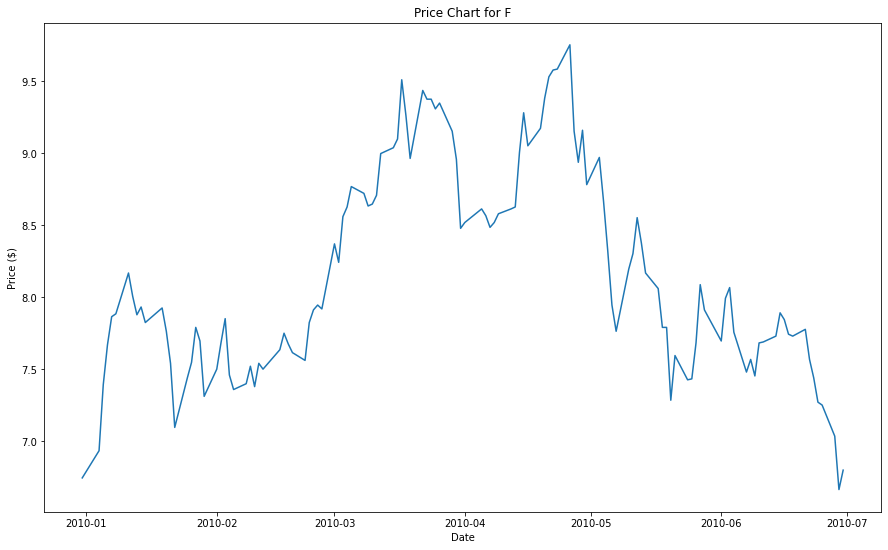

In [5]:
plt.figure(figsize=(15, 9))
plt.plot(data['Close'])
plt.title(f'Price Chart for {ticker}')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

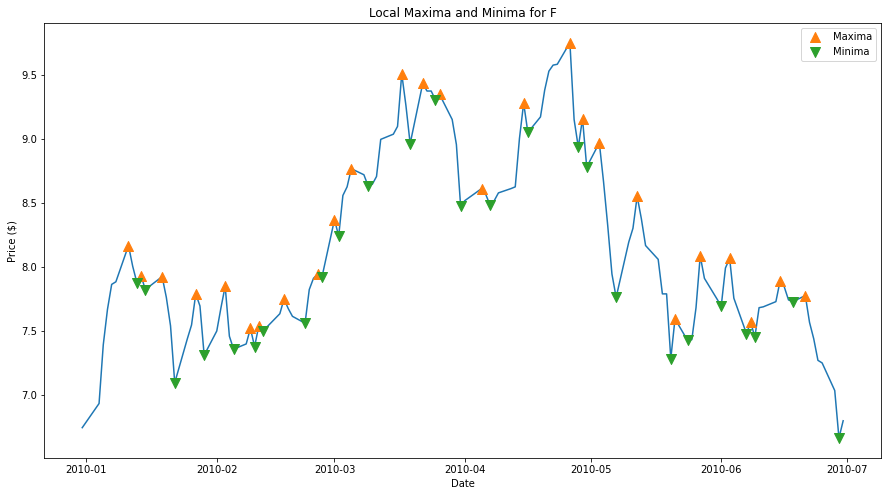

In [6]:

# data['Close'][True] --> return the close value of that row
# data['Close'][False] --> return NAN

data['local_max'] = data['Close'][(data['Close'].shift(1) < data['Close']) & (data['Close'].shift(-1) < data['Close'])]

data['local_min'] = data['Close'][(data['Close'].shift(1) > data['Close']) & (data['Close'].shift(-1) > data['Close'])]

max_lst = data['local_max'].tolist()
min_lst = data['local_min'].tolist()

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(15, 8))
plt.plot(data['Close'], zorder=0)

# scatter is the function responsible of drawing dots and shapes on the chart
plt.scatter(data.index, data['local_max'], s=100,label='Maxima', marker='^', c=colors[1])
plt.scatter(data.index, data['local_min'], s=100, label='Minima', marker='v', c=colors[2])

plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Local Maxima and Minima for {ticker}')
plt.legend()
plt.show()



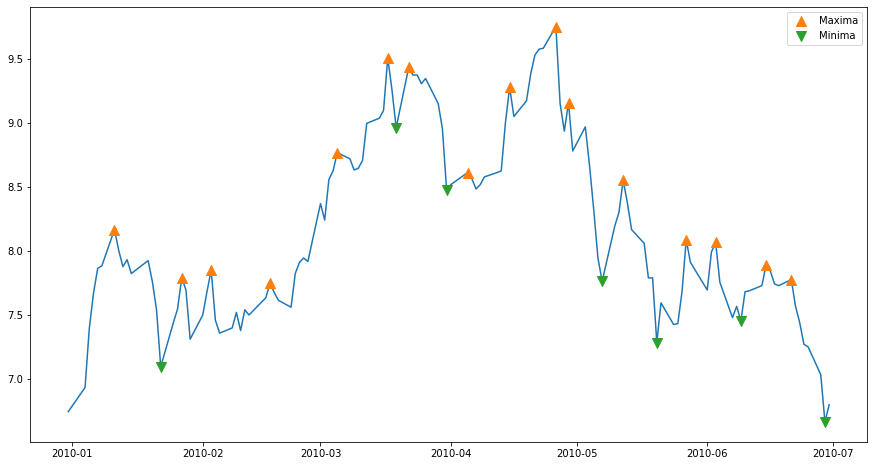

In [14]:
# max_idx and min_idx are the row numbers of the close price that coressponds to the peak or vally.
# thers are always implicit index in pandas df wich are 0 --> n , the explicit index may be a date or unixtime or  numbers.
# argrelextrema return a tuple, that tuple its first element is np array that contains the extremas that is why we use [0] 

max_idx = argrelextrema(data['Close'].values, np.greater, order=2)[0]
min_idx = argrelextrema(data['Close'].values, np.less, order=5)[0]

plt.figure(figsize=(15, 8))
plt.plot(data['Close'], zorder=0)
# iloc works with integer row numbers, sctter function take x values as first argument and y values as second argument
# he used data.iloc[min_idx].index instead of data.index because x and y must be the same size
plt.scatter(data.iloc[max_idx].index, data.iloc[max_idx]['Close'], label='Maxima', s=100, color=colors[1], marker='^')
plt.scatter(data.iloc[min_idx].index, data.iloc[min_idx]['Close'], label='Minima', s=100, color=colors[2], marker='v')
plt.legend()
plt.show()



In [8]:
# Get K consecutive higher peaks
K = 2
high_idx = argrelextrema(data['Close'].values, np.greater, order=5)[0]
highs = data.iloc[high_idx]['Close']

extrema = []
ex_deque = deque(maxlen=K)
for i, idx in enumerate(high_idx):

  if i == 0:
    ex_deque.append(idx)
    continue
  # the if block above is to make sure that the second if block works
  # because if i=0 then i-1 = ?

  if highs[i] < highs[i-1]:
    ex_deque.clear()
  
  # the if block above is to make sure that i got two consecutive higher highs
  # consecutive 

  ex_deque.append(idx)
  if len(ex_deque) == K:
    # K-consecutive higher highs found
    extrema.append(ex_deque.copy())

print(extrema)



[deque([22, 51], maxlen=2), deque([51, 78], maxlen=2)]


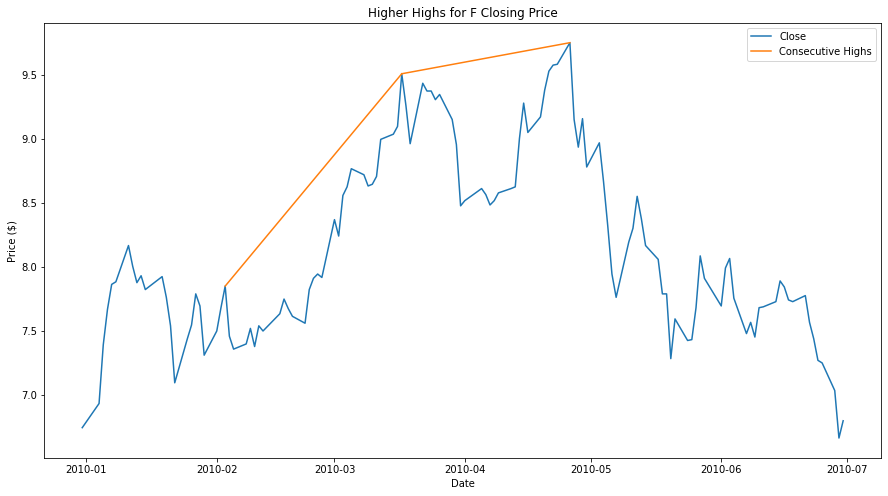

In [9]:
close = data['Close'].values
dates = data.index


plt.figure(figsize=(15, 8))
plt.plot(data['Close'])



# dates[i] gets two values from deque wich represent the x value of two diffrent points in chart
# close[i] gets two values from deque wich represent the y value of two diffrent points in chart
# then plt magicaly knows how to link and draw 

_ = [plt.plot(dates[i], close[i], c=colors[1]) for i in extrema]
# simpler version; use step by step debuger 
# for i in extrema:
#     plt.plot(dates[i], close[i])
#     plt.show()

plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Higher Highs for {ticker} Closing Price')
plt.legend(['Close', 'Consecutive Highs'])
plt.show()

In [10]:
def getHigherLows(data: np.array, order=5, K=2):
  '''
  Finds consecutive higher lows in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive lows need to be higher.
  '''
  # Get lows
  low_idx = argrelextrema(data, np.less, order=order)[0]
  lows = data[low_idx]
  # Ensure consecutive lows are higher than previous lows
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(low_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if lows[i] < lows[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

def getLowerHighs(data: np.array, order=5, K=2):
  '''
  Finds consecutive lower highs in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive highs need to be lower.
  '''
  # Get highs
  high_idx = argrelextrema(data, np.greater, order=order)[0]
  highs = data[high_idx]
  # Ensure consecutive highs are lower than previous highs
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(high_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if highs[i] > highs[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

def getHigherHighs(data: np.array, order=5, K=2):
  '''
  Finds consecutive higher highs in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive highs need to be higher.
  '''
  # Get highs
  high_idx = argrelextrema(data, np.greater, order=5)[0]
  highs = data[high_idx]
  # Ensure consecutive highs are higher than previous highs
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(high_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if highs[i] < highs[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

def getLowerLows(data: np.array, order=5, K=2):
  '''
  Finds consecutive lower lows in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive lows need to be lower.
  '''
  # Get lows
  low_idx = argrelextrema(data, np.less, order=order)[0]
  lows = data[low_idx]
  # Ensure consecutive lows are lower than previous lows
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(low_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if lows[i] > lows[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

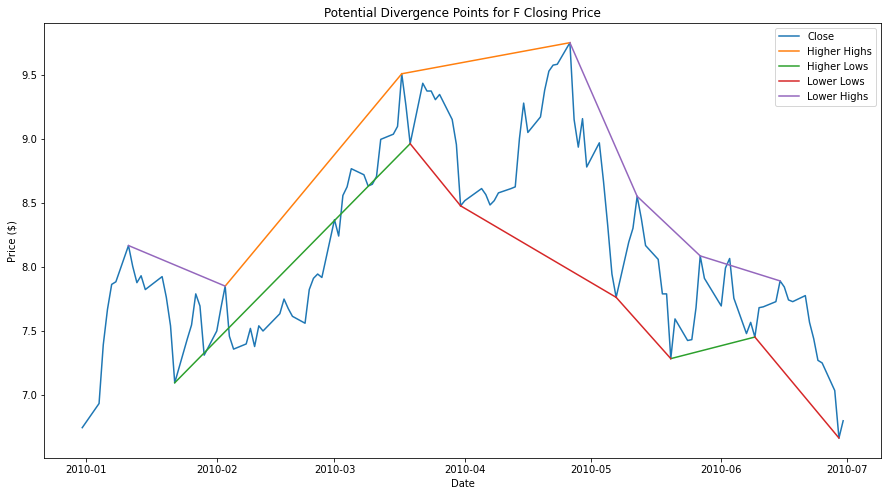

In [11]:
close = data['Close'].values
dates = data.index

order = 5
K = 2

hh = getHigherHighs(close, order, K)
hl = getHigherLows(close, order, K)
ll = getLowerLows(close, order, K)
lh = getLowerHighs(close, order, K)

plt.figure(figsize=(15, 8))
plt.plot(data['Close'])
_ = [plt.plot(dates[i], close[i], c=colors[1]) for i in hh]
_ = [plt.plot(dates[i], close[i], c=colors[2]) for i in hl]
_ = [plt.plot(dates[i], close[i], c=colors[3]) for i in ll]
_ = [plt.plot(dates[i], close[i], c=colors[4]) for i in lh]
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Potential Divergence Points for {ticker} Closing Price')
legend_elements = [
  Line2D([0], [0], color=colors[0], label='Close'),
  Line2D([0], [0], color=colors[1], label='Higher Highs'),
  Line2D([0], [0], color=colors[2], label='Higher Lows'),
  Line2D([0], [0], color=colors[3], label='Lower Lows'),
  Line2D([0], [0], color=colors[4], label='Lower Highs')
]
plt.legend(handles=legend_elements)
plt.show()

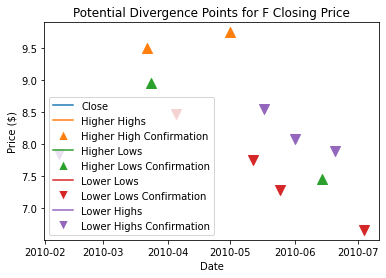

In [12]:



_ = [plt.scatter(dates[i[-1]] + timedelta(order), close[i[-1]], 
    c=colors[1], marker='^', s=100) for i in hh]
_ = [plt.scatter(dates[i[-1]] + timedelta(order), close[i[-1]], 
    c=colors[2], marker='^', s=100) for i in hl]
_ = [plt.scatter(dates[i[-1]] + timedelta(order), close[i[-1]], 
    c=colors[3], marker='v', s=100) for i in ll]
_ = [plt.scatter(dates[i[-1]] + timedelta(order), close[i[-1]],
    c=colors[4], marker='v', s=100) for i in lh]
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Potential Divergence Points for {ticker} Closing Price')
legend_elements = [
  Line2D([0], [0], color=colors[0], label='Close'),
  Line2D([0], [0], color=colors[1], label='Higher Highs'),
  Line2D([0], [0], color='w',  marker='^',
         markersize=10,
         markerfacecolor=colors[1],
         label='Higher High Confirmation'),
  Line2D([0], [0], color=colors[2], label='Higher Lows'),
  Line2D([0], [0], color='w',  marker='^',
         markersize=10,
         markerfacecolor=colors[2],
         label='Higher Lows Confirmation'),
  Line2D([0], [0], color=colors[3], label='Lower Lows'),
  Line2D([0], [0], color='w',  marker='v',
         markersize=10,
         markerfacecolor=colors[3],
         label='Lower Lows Confirmation'),
  Line2D([0], [0], color=colors[4], label='Lower Highs'),
  Line2D([0], [0], color='w',  marker='v',
         markersize=10,
         markerfacecolor=colors[4],
         label='Lower Highs Confirmation')
]
plt.legend(handles=legend_elements)
plt.show()